In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.9 MB 7.0 MB/s 
     |████████████████████████████████| 163 kB 54.6 MB/s 
     |████████████████████████████████| 6.6 MB 56.3 MB/s 


In [3]:
import torch
import numpy as np
import pandas as pd
import time
import datetime
import random
import os


from tqdm.notebook import tqdm

from torch.utils.data import TensorDataset,DataLoader, RandomSampler, SequentialSampler
from torch.optim import AdamW
from transformers import BertForSequenceClassification,BertTokenizer,get_linear_schedule_with_warmup,DataCollatorWithPadding

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import f1_score
from sklearn.utils.class_weight import compute_class_weight

import matplotlib.pyplot as plt
import seaborn as sns

from google.colab import files



In [4]:
dfOri = pd.read_csv('/content/drive/MyDrive/Kuliah/Skripsi/data+label+extended-v2.csv')
dfOri = dfOri.dropna(how='any',axis=0) 

print('before under sampling : ')
print('Number of training sentences: {:,}\n'.format(dfOri.shape[0]))
print(dfOri.label.value_counts())
print('\n')

aman = dfOri[dfOri['label']==0]
ragu = dfOri[dfOri['label']==1]
beresiko = dfOri[dfOri['label']==2]
aman_undersampling = aman.sample(n=1450, random_state=101)
df = pd.concat([aman_undersampling,ragu,beresiko],axis=0)

print('After under sampling : ')
print('Number of training sentences: {:,}\n'.format(df.shape[0]))
print(df.label.value_counts())
print('\n')
df.head()

before under sampling : 
Number of training sentences: 4,229

0    3375
1     682
2     172
Name: label, dtype: int64


After under sampling : 
Number of training sentences: 2,304

0    1450
1     682
2     172
Name: label, dtype: int64




,id,essay,label
2521,2522,I've ever been affected by covid-19 in last Ju...,0
3771,3772,"Generally speaking, there are six aspects of h...",0
3138,3139,"For my entire life(19 years)thanks to God,I ha...",0
356,357,I am fortunate enough to not have gone through...,0
2196,2197,"I‚Äôm a healthy person, so I don‚Äôt have medi...",0


In [5]:
# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla P100-PCIE-16GB


In [6]:

df['data_type'] = ['not_set']*df.shape[0]

X_train, X_test, y_train, y_test = train_test_split(df.index.values, 
                                                  df.label.values, 
                                                  test_size=0.30, 
                                                  random_state=42, 
                                                  stratify=df.label.values)
df.loc[X_train, 'data_type'] = 'train'
df.loc[X_test, 'data_type'] = 'test'
X_train, X_val, y_train, y_val = train_test_split(df[df.data_type=='train'].index.values, 
                                                  df[df.data_type=='train'].label.values, 
                                                  test_size=0.30, 
                                                  random_state=42, 
                                                  stratify=df[df.data_type=='train'].label.values)

label_dict = {
    'aman' : 0,
    'meragukan':1,
    'beresiko' : 2
}
df.loc[X_val, 'data_type'] = 'val'
df.groupby([ 'label', 'data_type']).count()

id  essay
label data_type            
0     test       435    435
      train      710    710
      val        305    305
1     test       205    205
      train      334    334
      val        143    143
2     test        52     52
      train       84     84
      val         36     36

In [10]:
def create_dataloader(data,tokenizer, samplerFunction = SequentialSampler):
  batch_size = 16
  encoded_data = tokenizer.batch_encode_plus(
      data.essay.values, 
      add_special_tokens=True, 
      return_attention_mask=True, 
      padding='max_length',
      max_length=512, 
      return_tensors='pt',
      truncation=True
  )
  print(encoded_data['input_ids'])
  input_ids = encoded_data['input_ids']
  attention_masks = encoded_data['attention_mask']
  labels = torch.tensor(data.label.values)

  dataset= TensorDataset(input_ids, attention_masks, labels)
  return DataLoader(dataset, 
            sampler=samplerFunction(dataset), 
            batch_size=batch_size)

In [7]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
data_train = df[df.data_type=='train']
data_validation = df[df.data_type=='val']
data_test = df[df.data_type=='test']
data_train_validation = df.drop(data_test.index)

data_collator = DataCollatorWithPadding(tokenizer)

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [15]:
batch_size = 16
encoded_data = tokenizer.batch_encode_plus(
    data_train.essay.values, 
    add_special_tokens=True, 
    return_attention_mask=True, 
    padding='max_length',
    max_length=512, 
    return_tensors='pt',
    truncation=True
)


torch.Size([1128, 512])

In [20]:
from pandas.plotting import table

In [26]:
print(tokenizer.convert_ids_to_tokens(encoded_data['input_ids'][0]))
print(encoded_data['input_ids'][0])

['[CLS]', 'i', "'", 've', 'ever', 'been', 'affected', 'by', 'co', '##vid', '-', '19', 'in', 'last', 'june', '2021', 'but', 'i', "'", 've', 'recovered', 'now', 'and', 'have', 'already', 'taken', 'the', 'co', '##vid', '-', '19', 'vaccine', '.', 'for', 'my', 'dental', 'and', 'oral', 'health', ',', 'it', "'", 's', 'always', 'healthy', 'even', 'i', "'", 've', 'never', 'had', 'tooth', '##ache', 'before', '.', 'in', 'junior', 'high', 'school', ',', 'i', "'", 've', 'ever', 'been', 'infected', 'by', 'deng', '##ue', 'fever', 'and', 'thy', '##ph', '##oid', 'fever', '.', 'but', 'ever', 'since', 'then', ',', 'i', "'", 've', 'never', 'been', 'infected', 'again', 'by', 'that', 'diseases', '.', 'for', 'any', 'others', 'condition', 'is', 'if', 'i', "'", 'm', 'too', 'stress', 'about', 'something', ',', 'i', 'will', 'feel', 'na', '##use', '##ous', '.', 'i', "'", 've', 'ever', 'been', 'to', 'take', 'the', 'mental', 'health', 'therapy', ',', 'the', 'doctor', 'gave', 'me', 'some', 'medicine', 'to', 'take', 

In [ ]:
def get_model():
  model = BertForSequenceClassification.from_pretrained("bert-base-uncased",
                                                      num_labels=len(label_dict),
                                                      output_attentions=False,
                                                      output_hidden_states=False,
                                                      )
  model.cuda()
  model.config.hidden_dropout_prob=0.45
  model.config.attention_probs_dropout_prob=0.45
  return model

In [ ]:
def f1_score_func(preds, labels):
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return f1_score(labels_flat, preds_flat, average='weighted')

def accuracy_per_class(preds, labels):
    label_dict_inverse = {v: k for k, v in label_dict.items()}
    
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    for label in np.unique(labels_flat):
        y_preds = preds_flat[labels_flat==label]
        y_true = labels_flat[labels_flat==label]
        print(f'class: {label_dict_inverse[label]}')
        print(f'Accuracy: {len(y_preds[y_preds==label])}/{len(y_true)}\n')

def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [ ]:
def get_class_weights(labels):
  weights = compute_class_weight(class_weight='balanced', classes=np.unique(labels),y=labels)
  class_weights= torch.tensor(weights,dtype=torch.float)
  class_weights = class_weights.to(device)
  return class_weights

In [ ]:
def get_optimizer(model, learningRate):
  return  AdamW(model.parameters(),
                lr = learningRate,
                eps=1e-8)

In [ ]:
def get_scheduler(num_training_steps, optimizer):
  return get_linear_schedule_with_warmup(optimizer,
                                         num_warmup_steps=0,
                                         num_training_steps=num_training_steps)

In [ ]:
def format_time(elapsed):
    elapsed_rounded = int(round((elapsed)))
    return str(datetime.timedelta(seconds=elapsed_rounded))


In [ ]:
def save_model(filename, output_dir, model):
  if not os.path.exists(output_dir):
      os.makedirs(output_dir)
  torch.save(model.state_dict(),f'{output_dir}/{filename}')

In [ ]:
def evaluate(dataloader,modelToTest,epoch,class_weights):

    modelToTest.eval()
    
    loss_val_total = 0
    predictions, true_vals = [], []
    accuracy_val_total = 0
    progress_bar = tqdm(dataloader,
                        desc='Epoch Eval {:1d}'.format(epoch),
                        leave=False,
                        disable=False)
    for batch in progress_bar:
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }

        with torch.no_grad():        
            outputs = modelToTest(**inputs)
            
        logits = outputs[1]
        criterion = torch.nn.CrossEntropyLoss(weight=class_weights)
        loss = criterion(logits, batch[2])
        loss_val_total += loss.item()
        logits = logits.detach().cpu().numpy()
        label_ids = inputs['labels'].cpu().numpy()

        accuracy_val_total += flat_accuracy(logits, label_ids)

        predictions.append(logits)
        true_vals.append(label_ids)
        progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item()/len(batch))})
    
    loss_val_avg = loss_val_total/len(dataloader) 
    
    predictions = np.concatenate(predictions, axis=0)
    true_vals = np.concatenate(true_vals, axis=0)
    avg_val_accuracy = accuracy_val_total / len(dataloader)

    return loss_val_avg, predictions, true_vals,avg_val_accuracy

In [ ]:
def train_and_validate(learning_rate,dataset_train,dataset_validation,epochs):
  total_t0 = time.time()
  training_stats = []
  best_loss = 1;
  best_loss_epoch = 0
  best_model_path = ""

  dataloader_train = create_dataloader(dataset_train,tokenizer,RandomSampler)
  dataloader_validation =  create_dataloader(data_validation,tokenizer)

  MAX_EPOCH_OVER_FITTING = 2
  overfitting_epoch_count = 0

  iterator_epoch = tqdm(range(1, epochs+1),
                        desc='Train learning rate-{:1f}'.format(learning_rate))
  num_training_steps = len(dataloader_train)*epochs
  model = get_model()
  optimizer = get_optimizer(model,learning_rate) 
  scheduler = get_scheduler(num_training_steps, optimizer)
  class_weights = get_class_weights(dataset_train.label.to_numpy())
  validation_class_weights = get_class_weights(dataset_validation.label.to_numpy())
  output_dir = f'./model/{learning_rate}'
  
  for epoch in iterator_epoch:
      t0 = time.time()
      model.train()
      loss_train_total = 0
      progress_bar = tqdm(dataloader_train, 
                          desc='Train Epoch-{:1d}'.format(epoch), 
                          leave=False, 
                          disable=False)
      for batch in progress_bar:
          model.zero_grad()
          
          batch = tuple(b.to(device) for b in batch)
          
          inputs = {'input_ids':      batch[0],
                    'attention_mask': batch[1],
                    'labels':         batch[2],
                  }       

          outputs = model(**inputs)
          logits = outputs[1]
          criterion = torch.nn.CrossEntropyLoss(weight=class_weights)
          loss = criterion(logits, batch[2])
          loss_train_total += loss.item()
          loss.backward()
          torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
          optimizer.step()
          scheduler.step()
          progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item()/len(batch))})

      training_time = format_time(time.time() - t0)
      loss_train_avg = loss_train_total/len(dataloader_train)
      
      filename = f'model_{epoch}.model'
      save_model(filename,output_dir, model)
      t0 = time.time()
      val_loss, predictions, true_vals,accuracy = evaluate(dataloader_validation,model, epoch,validation_class_weights )
      validation_time = format_time(time.time() - t0)
      val_f1 = f1_score_func(predictions, true_vals)
      training_stats.append(
          {
              'epoch': epoch,
              'Training Loss': loss_train_avg,
              'Valid. Loss': val_loss,
              'Accuracy' : accuracy,
              'Validation Time' : validation_time,
              'Training Time': training_time
          }
      )      
      tqdm.write(f'\nEpoch {epoch}')
      tqdm.write(f'Training loss: {loss_train_avg}')
      tqdm.write(f'Validation loss: {val_loss}')
      tqdm.write(f'F1 Score (Weighted): {val_f1}')
      tqdm.write(f'Training epcoh took: {training_time}')
      tqdm.write(f'Validation epcoh took: {validation_time}')
      
      if(val_loss < best_loss):
        best_loss = val_loss
        best_loss_epoch = epoch
        path = f'{output_dir}/{filename}'
        best_model_path=path
        overfitting_epoch_count = 0
      elif(overfitting_epoch_count + 1 >= MAX_EPOCH_OVER_FITTING ) :
        print('break because overfitting')
        iterator_epoch.close()
        break
      else:
        overfitting_epoch_count += 1

  return {
      'best_loss_epoch':best_loss_epoch, 
      'best_loss':best_loss, 
      'epochs':epochs, 
      'training_stats':training_stats,
      'best_model_path':best_model_path,
  }


In [ ]:
def show_lerning_rate_graph(training_stats):
  # Display floats with two decimal places.
  pd.set_option('precision', 2)

  # Create a DataFrame from our training statistics.
  df_stats = pd.DataFrame(data=best_training_stats)

  # Use the 'epoch' as the row index.
  df_stats = df_stats.set_index('epoch')
  # Use plot styling from seaborn.
  sns.set(style='darkgrid')

  # Increase the plot size and font size.
  sns.set(font_scale=1.5)
  plt.rcParams["figure.figsize"] = (12,6)

  # Plot the learning curve.
  plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
  plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

  # Label the plot.
  plt.title("Training & Validation Loss")
  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  plt.legend()
  # plt.xticks([1, 2, 3, 4])

  plt.show()

In [ ]:
seed_val = 17
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

best_loss = 1;
best_loss_epoch = 0
best_loss_learning_rate = 0
best_training_stats = []
best_model_path=""

max_learning_rate = 5e-5
current_learning_rate = 1e-5
epochs = 9

while(current_learning_rate < max_learning_rate):
  training_result = train_and_validate(current_learning_rate,
                                      data_train,
                                      data_validation,
                                      epochs)
  if(training_result['best_loss'] < best_loss):
    best_loss = training_result['best_loss']
    best_loss_epoch = training_result['best_loss_epoch']
    best_training_stats = training_result['training_stats']
    best_model_path = training_result['best_model_path']
    best_loss_learning_rate = current_learning_rate

  current_learning_rate += 5e-6  

show_lerning_rate_graph(best_training_stats)

In [ ]:
def show_stats_result(predictions,true_vals):
  val_pred = np.argmax(predictions, axis=-1)
  labels =["aman","meragukan","beresiko"]
  confusion_matrix = metrics.confusion_matrix(true_vals, val_pred)
  cm_display = metrics.ConfusionMatrixDisplay(
      confusion_matrix = confusion_matrix, 
      display_labels=labels,
      )
  report =metrics.classification_report(true_vals, val_pred, labels=[0,1,2])
  cm_display.plot()
  plt.show()
  print(report)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Epoch Eval 9:   0%|          | 0/44 [00:00<?, ?it/s]

class: aman
Accuracy: 371/435

class: meragukan
Accuracy: 140/205

class: beresiko
Accuracy: 31/52



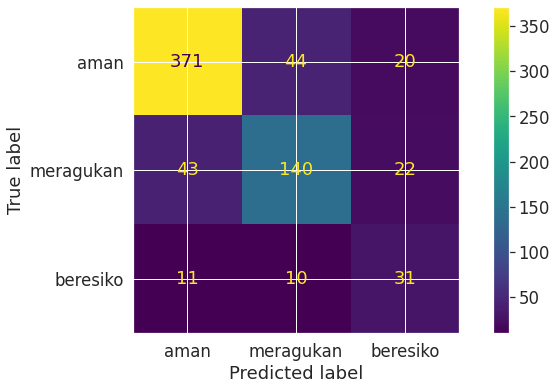

              precision    recall  f1-score   support

           0       0.87      0.85      0.86       435
           1       0.72      0.68      0.70       205
           2       0.42      0.60      0.50        52

    accuracy                           0.78       692
   macro avg       0.67      0.71      0.69       692
weighted avg       0.79      0.78      0.79       692



In [ ]:
modelLoad = BertForSequenceClassification.from_pretrained("bert-base-uncased",
                                                      num_labels=len(label_dict),
                                                      output_attentions=False,
                                                      output_hidden_states=False)
modelLoad.to(device)
modelLoad.load_state_dict(torch.load(best_model_path))
dataloader_test =  create_dataloader(data_test,tokenizer)
validation_class_weights = get_class_weights(data_test.label.to_numpy())

_, predictions, true_vals,_ = evaluate(dataloader_test,modelLoad, 9, validation_class_weights)
accuracy_per_class(predictions,true_vals)
show_stats_result(predictions,true_vals)

In [ ]:
result_training = train_only(best_loss_learning_rate,data_train_validation,epochs)
model_combine = result_training['model']
dataloader_test =  create_dataloader(data_test,tokenizer)
_, predictions, true_vals,_ = evaluate(dataloader_test,model_combine)
show_lerning_rate_graph(result_training['training_stats'])
accuracy_per_class(predictions,true_vals)
show_stats_result(predictions,true_vals)

  0%|          | 0/9 [00:00<?, ?it/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Train Epoch=1 LR=0.000030:   0%|          | 0/101 [00:00<?, ?it/s]


Epoch 1
Training loss: 0.683038225697727
Training epcoh took: 0:01:25


Train Epoch=2 LR=0.000030:   0%|          | 0/101 [00:00<?, ?it/s]


Epoch 2
Training loss: 0.8519283470635459
Training epcoh took: 0:01:25


Train Epoch=3 LR=0.000030:   0%|          | 0/101 [00:00<?, ?it/s]


Epoch 3
Training loss: 0.5498660522124657
Training epcoh took: 0:01:25


Train Epoch=4 LR=0.000030:   0%|          | 0/101 [00:00<?, ?it/s]


Epoch 4
Training loss: 0.5714812609136547
Training epcoh took: 0:01:25


Train Epoch=5 LR=0.000030:   0%|          | 0/101 [00:00<?, ?it/s]


Epoch 5
Training loss: 0.9399036566224318
Training epcoh took: 0:01:25


Train Epoch=6 LR=0.000030:   0%|          | 0/101 [00:00<?, ?it/s]


Epoch 6
Training loss: 0.8735830066616113
Training epcoh took: 0:01:25


Train Epoch=7 LR=0.000030:   0%|          | 0/101 [00:00<?, ?it/s]


Epoch 7
Training loss: 0.5737374324690422
Training epcoh took: 0:01:25


Train Epoch=8 LR=0.000030:   0%|          | 0/101 [00:00<?, ?it/s]


Epoch 8
Training loss: 2.179922083680896
Training epcoh took: 0:01:25


Train Epoch=9 LR=0.000030:   0%|          | 0/101 [00:00<?, ?it/s]


Epoch 9
Training loss: 1.8597903717678077
Training epcoh took: 0:01:25


TypeError: ignored

Epoch Eval 9:   0%|          | 0/44 [00:00<?, ?it/s]

class: aman
Accuracy: 435/435

class: meragukan
Accuracy: 0/205

class: beresiko
Accuracy: 0/52



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


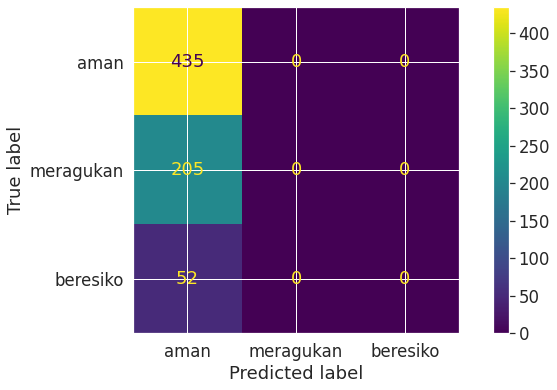

              precision    recall  f1-score   support

           0       0.63      1.00      0.77       435
           1       0.00      0.00      0.00       205
           2       0.00      0.00      0.00        52

    accuracy                           0.63       692
   macro avg       0.21      0.33      0.26       692
weighted avg       0.40      0.63      0.49       692



In [ ]:
validation_class_weights = get_class_weights(data_test.label.to_numpy())
_, predictions, true_vals,_ = evaluate(dataloader_test,model_combine, 9, validation_class_weights)
accuracy_per_class(predictions,true_vals)
show_stats_result(predictions,true_vals)

In [ ]:
# dfKosong = pd.read_csv('/content/drive/MyDrive/Kuliah/Skripsi/batch3.csv')
# dfKosong = dfKosong.dropna(how='any',axis=0)

# encoded_data_kosong = tokenizer.batch_encode_plus(
#     dfKosong.essay.values, 
#     add_special_tokens=True, 
#     return_attention_mask=True, 
#     padding='max_length',
#     max_length=512, 
#     return_tensors='pt',
#     truncation=True
# )

# input_ids_kosong = encoded_data_kosong['input_ids']
# attention_masks_kosong = encoded_data_kosong['attention_mask']
# labels_kosong = torch.tensor(dfKosong.label.values)

# dataset_kosong = TensorDataset(input_ids_kosong, attention_masks_kosong, labels_kosong)

# dataloader_kosong = DataLoader(dataset_kosong, 
#                                    sampler=SequentialSampler(dataset_kosong), 
#                                    batch_size=batch_size)

In [ ]:
# preds_flat = np.argmax(predictions, axis=1).flatten()
# newDf = pd.DataFrame(preds_flat)
# newDf.head()

In [ ]:
# print(newDf.shape)
# print(newDf.value_counts())

In [ ]:
# newDf.to_csv('predictions.csv') 
# files.download("predictions.csv")